# 4. Mallas e Integración 2D
#### Integral:
$$\iint \limits_{\Omega} \left(sin(\pi x) \cdot cos^2(\pi y)\right) d\Omega$$
#### Dominio: 
$$\Omega = \left\lbrace 0, 5 \right\rbrace \times \left\lbrace 0, 2 \right\rbrace \ \cup \ \left\lbrace 2, 7 \right\rbrace \times \left\lbrace 2, 4 \right\rbrace$$

Para la integración 2D con el Método de Cuadraturas Gaussianas se hace uso de la función ***gaussian_integration_2D*** creada por **© Daniel Giraldo Cuartas 2022**:

In [60]:
import numpy as np
import sympy as sym
import pyvista as pv
import meshio

x, y = sym.symbols('x y')
f = sym.sin(sym.pi*x)*sym.cos(sym.pi*y)**2

xla1, xlb1 = (0, 5)
xla2, xlb2 = (2, 7)
yla1, ylb1 = (0, 2)
yla2, ylb2 = (2, 4)

analyticalIntegral = round(sym.integrate(f, (y, yla1, ylb1), (x, xla1, xlb1)) + sym.integrate(f, (y, yla2, ylb2), (x, xla2, xlb2)),7)
print('Integral analítica: ', analyticalIntegral)

Integral analítica:  1.2732395


In [61]:
def gaussian_integration_2D(p0, p1, p2, p3, fun, nx, ny):
    '''
        - p0, p1, p2, p3:
            Coordenadas de los punto (x,y) del cuadrilatero
        
        - fun:
            Funcion lambda f(x,y) a interpolar
            
        - nx, ny:
            Numero de puntos de cuadratura a utilizar en direccion
            x, y respectivamente.
    '''
    xi, wi = np.polynomial.legendre.leggauss(nx)
    yj, wj = np.polynomial.legendre.leggauss(ny)
    
    X = np.matrix([p0, p1, p2, p3])
    
    
    Nt = lambda r,s : 0.25*np.array([
        (1-r)*(1-s),
        (1+r)*(1-s),
        (1+r)*(1+s),
        (1-r)*(1+s)
        ])
    
    Dt = lambda r,s : 0.25*np.array([
        [s-1, r-1],
        [1-s, -1-r],
        [1+s, 1+r],
        [-1-s, 1-r]
        ]).transpose()
    
    integral = 0
    for i in range(nx):
        rx = xi[i]
        wx = wi[i]
        for j in range(ny):
            sy = yj[j]
            wy = wj[j]
            
            J = Dt(rx, sy)*X
            det_J = np.linalg.det(J)
            
            x_vec = Nt(rx, sy)*X
            f_val = fun(x_vec[0,0], x_vec[0,1])
            integral += (f_val)*det_J*wx*wy
            
    return integral

El dominio de integracion $\Omega$ corresponde al mostrado en la siguiente figura. Para almacenar este dominio, se hace una malla con dos rectangulos apartir de los puntos dados.  

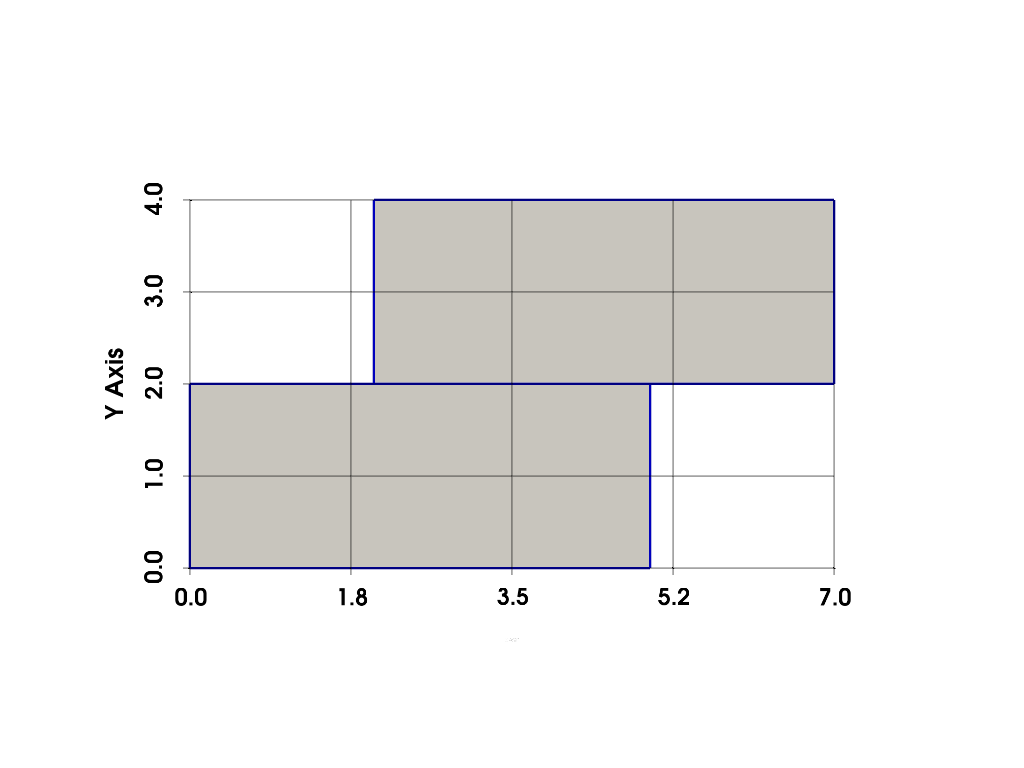

In [62]:
points = np.array([
    [0,0], 
    [5,0],
    [5,2],
    [0,2],
    ##
    [2,2],
    [7,2],
    [7,4],
    [2,4]
], dtype='float32')

rectangles = np.array([
    [0,1,2,3],
    [4,5,6,7],
], dtype='int32')

cells = [("quad", rectangles)]
original_mesh = meshio.Mesh(points, cells)

original_mesh_pv = pv.wrap(original_mesh)

pl = pv.Plotter()
pl.add_mesh(original_mesh_pv, color='white')
pl.add_mesh(original_mesh_pv, color="blue", style='wireframe', line_width=3)
pl.view_xy()
pl.show_grid()
pl.show(jupyter_backend='pythreejs')

A continuación se procede a subdividir en rectangulos la malla anterior en dos mallas estructuradas (a partir de los dos rectangulos que se tenían anteriormente) según la cantidad de rectangulos que se deseen en cada una de las dos direcciones. 

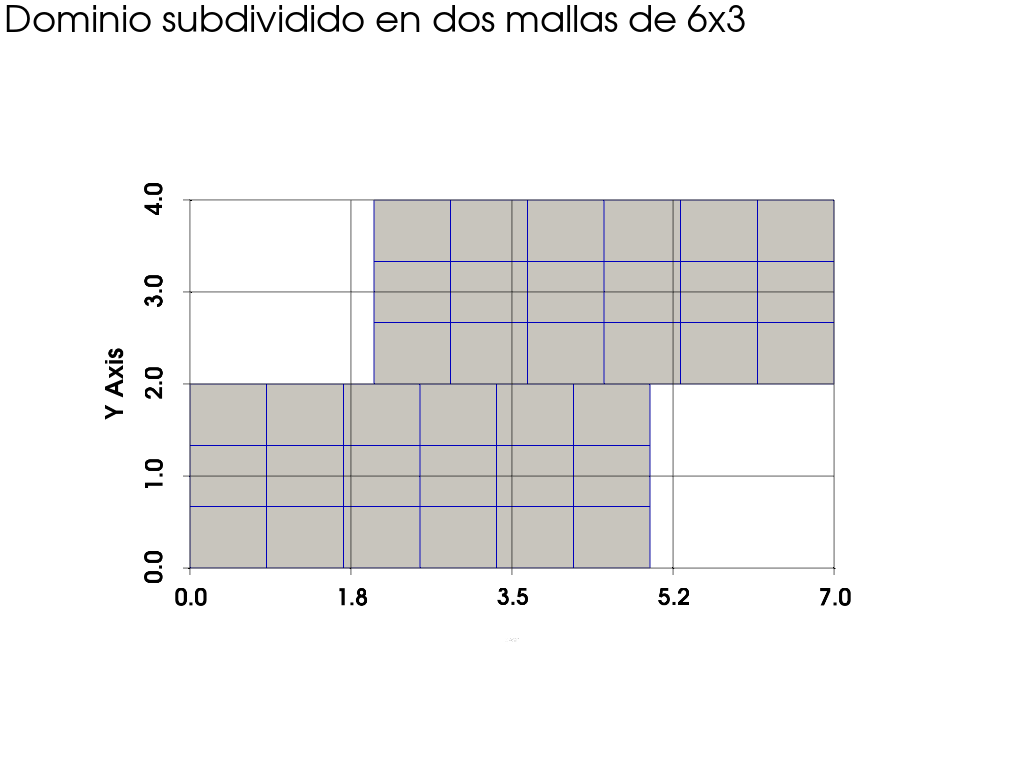

In [73]:
def domain_mesh(rectangles, points, n, z):
    ps = []
    rs = []

    for m in range(len(rectangles)):
        xs = np.linspace(points[rectangles[m][0]][0], points[rectangles[m][1]][0], n+1)
        ys = np.linspace(points[rectangles[m][0]][1], points[rectangles[m][2]][1], z+1)
        for j in range(z+1):
            for i in range(n+1):
                ps.append([xs[i], ys[j]])
                
                if (j == z)|(i == n):
                    pass
                else:
                    n1 = (j*n + j + i) + m*(n+1)*(z+1)
                    n2 = n1 + 1
                    n3 = n2+n+1
                    n4 = n3-1
                    rs.append([n1, n2, n3, n4])
    return ps, rs
    
def mesh_plot(rs, ps, n, z): 
    cells = [("quad", rs)]
    mesh = meshio.Mesh(ps, cells)

    mesh_pv = pv.wrap(mesh)

    pl2 = pv.Plotter()
    pl2.add_mesh(mesh_pv, color='white')
    pl2.add_mesh(mesh_pv, color="blue", style='wireframe', line_width=1.5)
    pl2.add_text(f"Dominio subdividido en dos mallas de {n}x{z}", font_size=20)
    pl2.view_xy()
    pl2.show_grid()
    pl2.show(jupyter_backend='pythreejs')
    
if __name__ == "__main__":
    n = 6
    z = 3
    ps, rs = domain_mesh(rectangles, points, n, z)
    mesh_plot(rs, ps, n, z)

Seguidamente se procede a realizar una integración con el método de cuadraturas gaussianas para cada rectangulo para posteriormente sumar cada resultado y hallar el valor de la integral requerida.

In [74]:
def mesh_integration(ps, rs, fun, nx, ny, n, z, analyticalIntegral):
    integral = 0
    for i in range(len(rs)):
        p0 = ps[rs[i][0]]
        p1 = ps[rs[i][1]]
        p2 = ps[rs[i][2]]
        p3 = ps[rs[i][3]]

        integral_num = gaussian_integration_2D(p0, p1, p2, p3, fun, nx, ny)
        
        integral += integral_num
        
    errorR = (round(100*abs(integral-analyticalIntegral)/analyticalIntegral,7))
        
    print(f"Integral numérica para las dos mallas de {n}x{z}: ", integral)
    print(f"Error relativo: {errorR} %")
    
    return integral
    
if __name__ == "__main__":
    
    fun = lambda x, y: np.sin(np.pi*x)*np.cos(np.pi*y)**2
    nx = 3
    ny = 3
    ps, rs = domain_mesh(rectangles, points, n, z)
    integral = mesh_integration(ps, rs, fun, nx, ny, n,z, analyticalIntegral)
        

Integral numérica para las dos mallas de 6x3:  1.2735010139715246
Error relativo: 0.0205392 %


Comparacion entre diferentes subdivisiones cuadriculadas de la mallas:

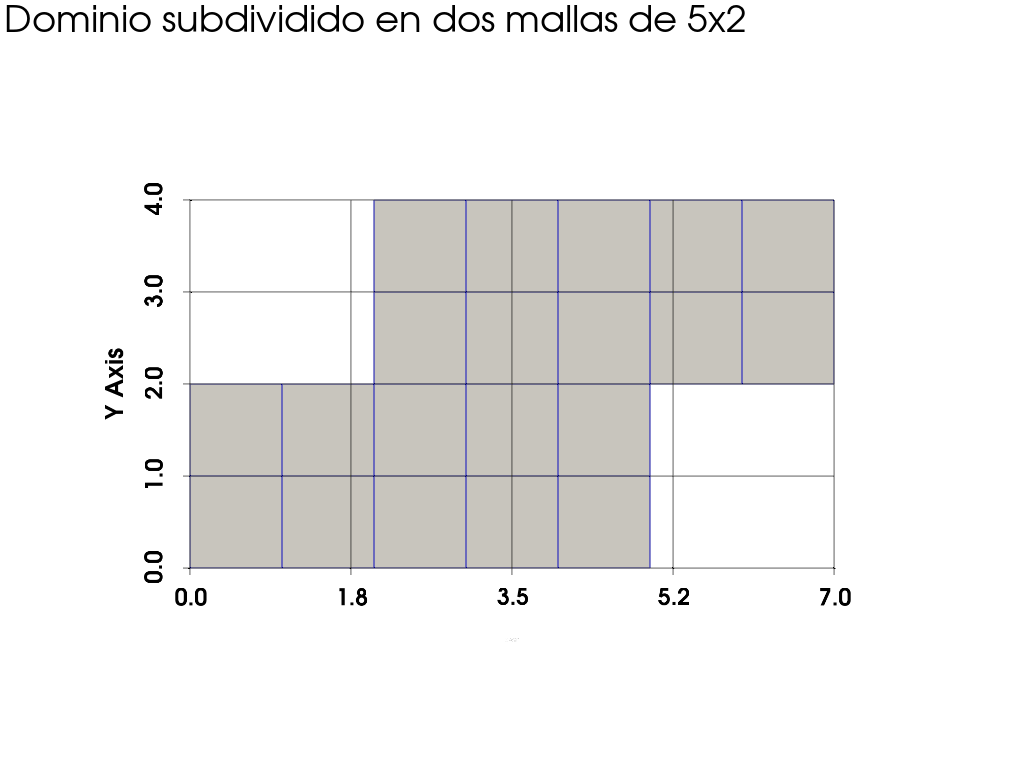

Integral numérica para las dos mallas de 5x2:  1.245514324387563
Error relativo: 2.1775303 %


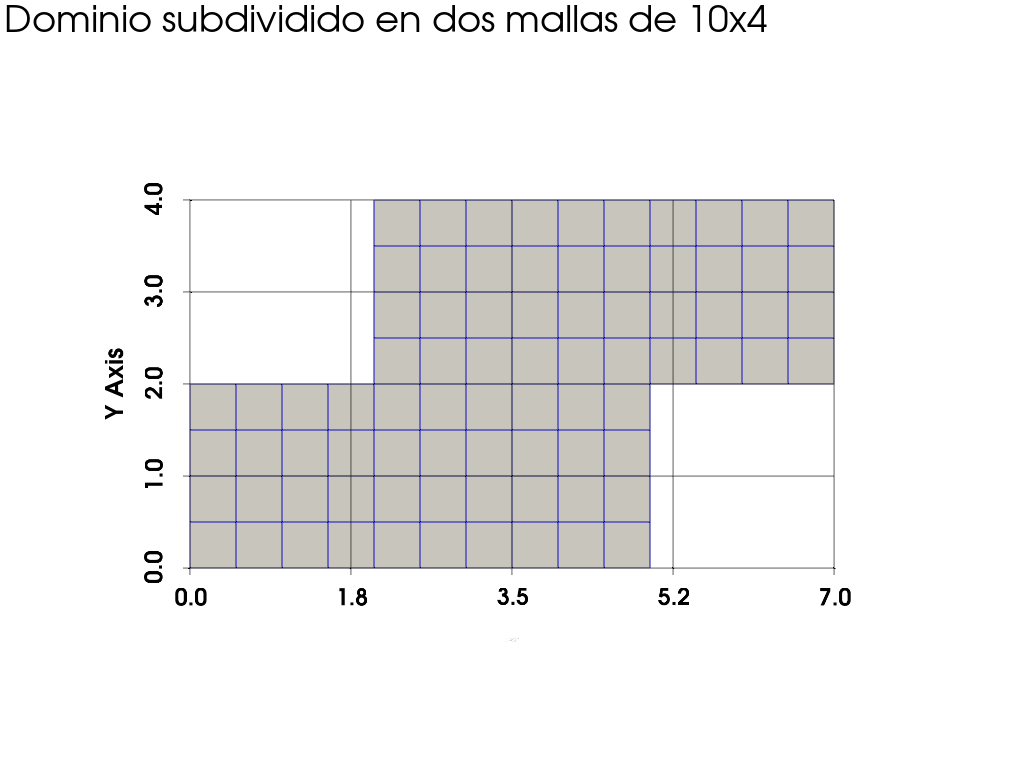

Integral numérica para las dos mallas de 10x4:  1.2732498854207883
Error relativo: 0.0008156 %


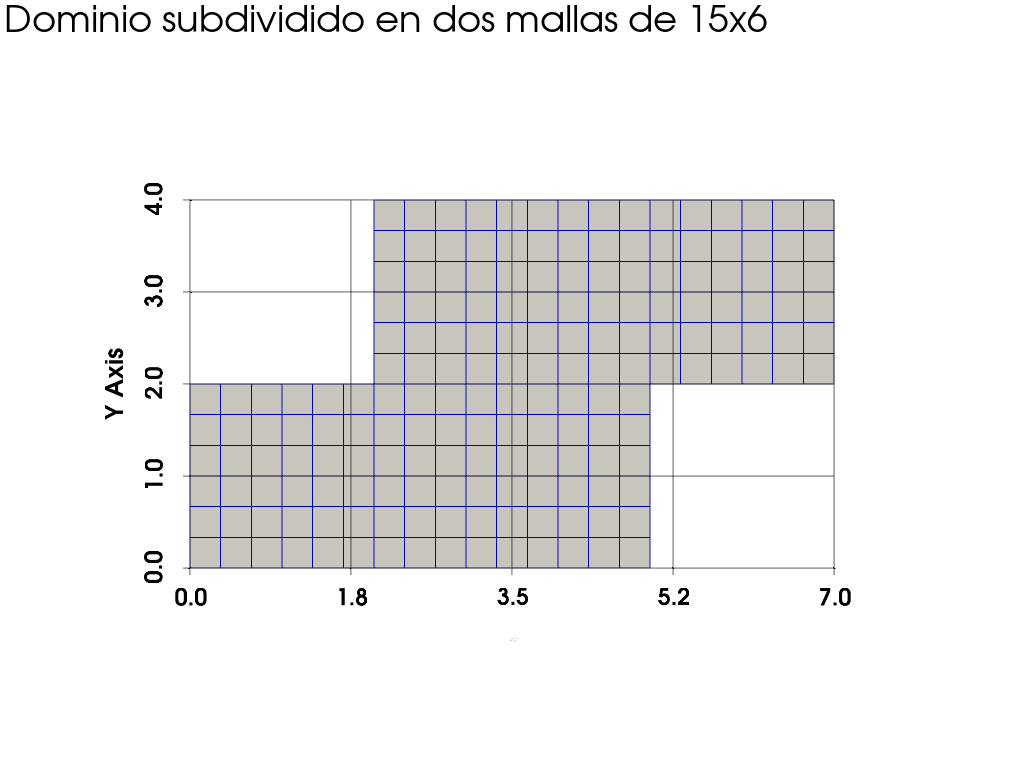

Integral numérica para las dos mallas de 15x6:  1.273240409663487
Error relativo: 0.0000714 %


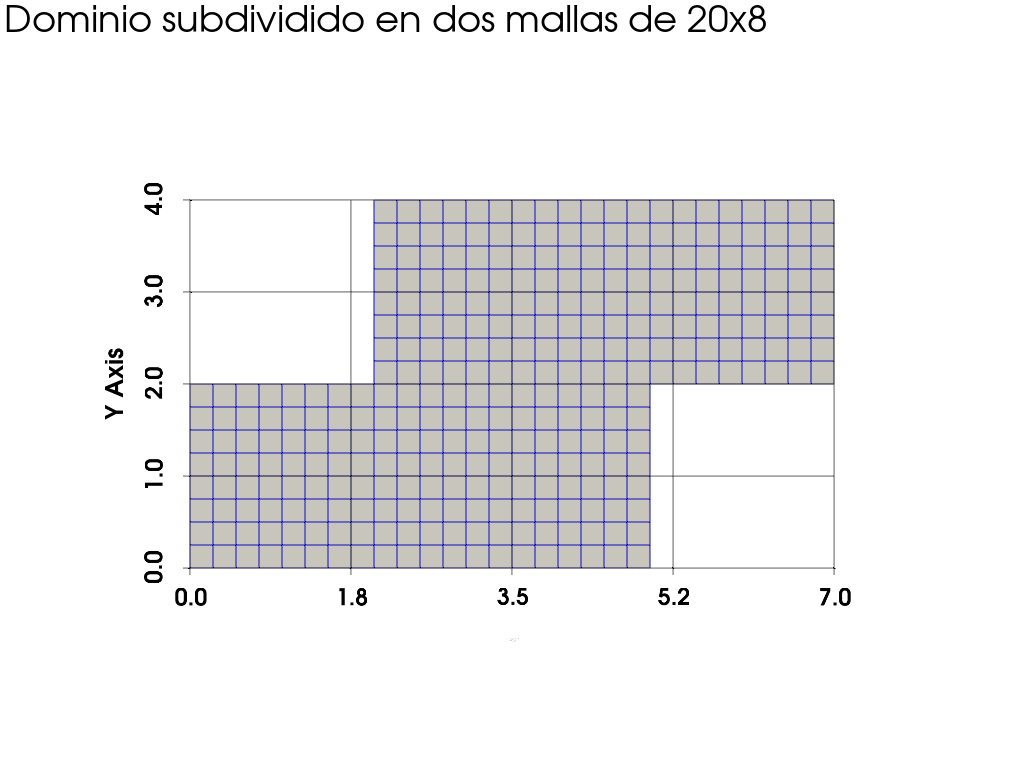

Integral numérica para las dos mallas de 20x8:  1.2732396961373493
Error relativo: 0.0000153 %


In [65]:
def mesh_comparison(f, rectangles, points, fun, nx, ny, analyticalIntegral):
    p = np.arange(1, f + 1)*5
    q = np.arange(1, f + 1)*2
    integrals = []
    for n,z in zip(p, q):
        ps, rs = domain_mesh(rectangles, points, n, z)
        mesh_plot(rs, ps, n, z)
        integrals.append(mesh_integration(ps, rs, fun, nx, ny, n, z, analyticalIntegral))
    return integrals
    
if __name__ == "__main__":
    fun = lambda x, y: np.sin(np.pi*x)*np.cos(np.pi*y)**2
    f = 4 #numero de comparaciones
    nx = 3
    ny = 3
    integrals = mesh_comparison(f, rectangles, points, fun, nx, ny, analyticalIntegral)